In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [2]:
def make_query(query, filepath='database.sqlite'):
    """
    Execute a query on a SQLite database file and return the results as a pandas DataFrame.

    Parameters
    ----------
    query : str
        SQL query to be executed on the database file.
    filepath : str, optional
        Path to the database file, by default 'database.sqlite'.

    Returns
    -------
    pd.DataFrame
        A pandas DataFrame containing the results of the executed query.
    """
    with sqlite3.connect(filepath) as connection:
        cursor = connection.cursor()
        execution = cursor.execute(query)
        result = pd.DataFrame(execution.fetchall(), columns=[i[0] for i in execution.description])
        return result

In [3]:
player_attributes = make_query(""" SELECT * FROM player_attributes """)
player = make_query(""" SELECT * FROM player """)
match = make_query(""" SELECT * FROM match """)
team = make_query(""" SELECT * FROM team """)
team_attributes = make_query(""" SELECT * FROM team_attributes """)
league = make_query(""" SELECT * FROM league """)
country = make_query(""" SELECT * FROM country """)

## Benoem op basis van bovenstaande met welke vorm van supervised learning we hier te maken hebben.
Omdat er 3 mogelijke beslissingen zijn, wordt dit een "multi-class classification" probleem genoemd. Merk hierbij op dat beslissingsopties op een "ordinale" schaal liggen. De 3 mogelijke beslissingen zijn win, draw of defeat


# Voeg het resultaat van iedere wedstrijd toe aan het match dataframe.

In [4]:

result = []
for row in match.itertuples():
    if row.home_team_goal == row.away_team_goal:
        result.append('draw')
    elif row.home_team_goal > row.away_team_goal:
        result.append('win')
    else:
        result.append('defeat')
match["result"] = result
match
#302 ms ± 11.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,result
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.73,3.40,5.00,1.75,3.35,4.20,1.85,3.2,3.5,1.80,3.3,3.75,NaN,NaN,NaN,1.70,3.30,4.33,1.90,3.3,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20,draw
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.95,3.20,3.60,1.80,3.30,3.95,1.90,3.2,3.5,1.90,3.2,3.50,NaN,NaN,NaN,1.83,3.30,3.60,1.95,3.3,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60,draw
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,2.38,3.30,2.75,2.40,3.30,2.55,2.60,3.1,2.3,2.50,3.2,2.50,NaN,NaN,NaN,2.50,3.25,2.40,2.63,3.3,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75,defeat
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.44,3.75,7.50,1.40,4.00,6.80,1.40,3.9,6.0,1.44,3.6,6.50,NaN,NaN,NaN,1.44,3.75,6.00,1.44,4.0,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50,win
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,5.00,3.50,1.65,5.00,3.50,1.60,4.00,3.3,1.7,4.00,3.4,1.72,NaN,NaN,NaN,4.20,3.40,1.70,4.50,3.5,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67,defeat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [5]:
#https://stackoverflow.com/questions/35321812/move-column-in-pandas-dataframe
column_to_move = match.pop("result")

match.insert(11, "result", column_to_move)
match

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,result,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,draw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.73,3.40,5.00,1.75,3.35,4.20,1.85,3.2,3.5,1.80,3.3,3.75,NaN,NaN,NaN,1.70,3.30,4.33,1.90,3.3,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0,draw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.95,3.20,3.60,1.80,3.30,3.95,1.90,3.2,3.5,1.90,3.2,3.50,NaN,NaN,NaN,1.83,3.30,3.60,1.95,3.3,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3,defeat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,2.38,3.30,2.75,2.40,3.30,2.55,2.60,3.1,2.3,2.50,3.2,2.50,NaN,NaN,NaN,2.50,3.25,2.40,2.63,3.3,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,0,win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.44,3.75,7.50,1.40,4.00,6.80,1.40,3.9,6.0,1.44,3.6,6.50,NaN,NaN,NaN,1.44,3.75,6.00,1.44,4.0,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,3,defeat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,5.00,3.50,1.65,5.00,3.50,1.60,4.00,3.3,1.7,4.00,3.4,1.72,NaN,NaN,NaN,4.20,3.40,1.70,4.50,3.5,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

# Maak een keuze voor de ‘features’ die je wilt gebruiken om het resultaat te voorspellen. Onderbouw je keuzes.

In [6]:
def add_attributes(data=match, attribute='overall_rating'):
    """
    Add player rating attributes to a dataset based on player attributes dataset.

    Parameters
    ----------
    data : pd.DataFrame, optional
        The match dataset to add player rating attributes to. By default match.
    attribute : str, optional
        The player attribute to use for calculating the player rating, by default 'overall_rating'.

    Returns
    -------
    pd.DataFrame
        A copy of the original match dataset with added player rating attributes.
    """
    player_columns = ['home_player_' + str(i) for i in range(1, 12)] + ['away_player_' + str(i) for i in range(1, 12)]
    player_ratings = round(player_attributes.groupby('player_api_id')[attribute].mean(), 0)

    for column in player_columns:
        rating_column = column + '_rating'
        data[rating_column] = data[column].apply(lambda x: player_ratings[x] if not np.isnan(x) else np.nan)
    
    return data

def team_ratings(data=match, season='2014/2015', attribute='overall_rating'):
    """
    Calculates the average attribute ratings.
    
    Parameters
    ----------
    data : pd.DataFrame, optional
        A DataFrame containing the match data, with columns 'home_team_api_id', 'away_team_api_id', and 'season' and by default match.
    season : str, optional
        The season for which to calculate the team ratings, in the format 'yyyy/yyyy' and by default '20014/2015'.
    attribute : str, optional
        The name of the attribute to use for the team ratings, by default 'overall_rating'.
        
    Returns
    -------
    pd.DataFrame
        A DataFrame containing the team names and their attribute ratings for the given season.
    """
    home_ratings = data.groupby(['home_team_api_id']).mean().iloc[:, -22:-11].mean(axis=1)
    away_ratings = data.groupby('away_team_api_id').mean().iloc[:, -11:].mean(axis=1)
  
    ratings = pd.concat([home_ratings, away_ratings], axis=1).mean(axis=1).reset_index()
    
    return pd.merge(team[['team_api_id', 'team_long_name']], ratings, left_on='team_api_id', right_on='index').drop(['index'], axis=1).rename(columns={0 : attribute})


# Maak een keuze voor de ‘features’ die je wilt gebruiken om het resultaat te voorspellen. Onderbouw je keuzes.

In [7]:
match = add_attributes()
match['Result'] = result
match['Result_numeric'] = match['Result'].replace({'win' : 3, 'draw' : 2, 'defeat' : 1})

ls = ['crossing','finishing', 'short_passing', 'volleys', 'dribbling','curve', 'free_kick_accuracy', 'ball_control', 'acceleration', 'agility',  'balance', 'jumping', 'positioning', 'vision']
df_eind = pd.DataFrame()
for x in ls:
    teste = add_attributes(attribute = x)
    tst = team_ratings(data = teste)


    match_ = pd.merge(match, tst, left_on='home_team_api_id', right_on='team_api_id').rename(columns={'potential' : 'home_rating'})
    test1 = pd.merge(match_, tst, left_on='away_team_api_id', right_on='team_api_id').rename(columns={'potential' : 'away_rating'})

    test1['differnce'] = test1['overall_rating_x'] - test1['overall_rating_y']
    test2 = test1[['differnce', 'Result_numeric']]
    df_eind[x] =test1['differnce']
    
df_eind['score'] = test1['Result_numeric']


### De dataframe df_eind voldoet aan de volgende eisen om een voorspellend model te maken
- Er zitten numerieke waarden
- Geen missende waardes
- Het is normaal verdeeld

In [14]:
display(df_eind.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25979 entries, 0 to 25978
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   crossing            25979 non-null  float64
 1   finishing           25979 non-null  float64
 2   short_passing       25979 non-null  float64
 3   volleys             25979 non-null  float64
 4   dribbling           25979 non-null  float64
 5   curve               25979 non-null  float64
 6   free_kick_accuracy  25979 non-null  float64
 7   ball_control        25979 non-null  float64
 8   acceleration        25979 non-null  float64
 9   agility             25979 non-null  float64
 10  balance             25979 non-null  float64
 11  jumping             25979 non-null  float64
 12  positioning         25979 non-null  float64
 13  vision              25979 non-null  float64
 14  score               25979 non-null  int64  
dtypes: float64(14), int64(1)
memory usage: 3.2 MB


None

### Maak op basis hiervan een nieuw dataframe dat alleen de features en het resultaat per wedstrijd bevat.

In [15]:
display(df_eind)


,crossing,finishing,short_passing,volleys,dribbling,curve,free_kick_accuracy,ball_control,acceleration,agility,balance,jumping,positioning,vision,score
0,1.321084,2.542702,1.924751,3.633504,3.215759,2.604648,-0.591950,3.200204,3.432221,1.424733,0.848382,2.706280,0.861105,0.807293,2
1,1.321084,2.542702,1.924751,3.633504,3.215759,2.604648,-0.591950,3.200204,3.432221,1.424733,0.848382,2.706280,0.861105,0.807293,2
2,1.321084,2.542702,1.924751,3.633504,3.215759,2.604648,-0.591950,3.200204,3.432221,1.424733,0.848382,2.706280,0.861105,0.807293,3
3,1.321084,2.542702,1.924751,3.633504,3.215759,2.604648,-0.591950,3.200204,3.432221,1.424733,0.848382,2.706280,0.861105,0.807293,3
4,1.321084,2.542702,1.924751,3.633504,3.215759,2.604648,-0.591950,3.200204,3.432221,1.424733,0.848382,2.706280,0.861105,0.807293,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25974,-3.139662,-2.295255,-1.458962,-2.234373,-3.614915,-3.767546,-3.388173,-3.141841,-0.111652,0.200143,-1.557891,-0.275100,-3.236376,-2.768769,1
25975,-3.139662,-2.295255,-1.458962,-2.234373,-3.614915,-3.767546,-3.388173,-3.141841,-0.111652,0.200143,-1.557891,-0.275100,-3.236376,-2.768769,1
25976,-3.139662,-2.295255,-1.458962,-2.234373,-3.614915,-3.767546,-3.388173,-3.141841,-0.111652,0.200143,-1.557891,-0.275100,-3.236376,-2.768769,2
25977,-9.880526,-10.879100,-6.957761,-8.636619,-9.004616,-6.230673,-9.072173,-6.446587,-2.843453,-1.426191,1.815030,-4.062682,-10.256439,-7.224630,3


# Gebruik minimaal twee algoritmes om de resultaten van de wedstrijden te voorspellen. Onderbouw je keuzes.

### KNeighborsClassifier

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

numeric_columns = ['crossing', 'finishing', 'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy', 'ball_control', 'acceleration', 'agility', 'balance', 'jumping', 'positioning', 'vision']
X = df_eind[numeric_columns]
y = df_eind['score']

# Split de data in trainings- en testsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train) 
predictions = knn.predict(X_test) 
display(predictions) 

comp = pd.DataFrame(y_test)
comp['predictions'] = predictions
comp['dif'] = comp['score'] - comp['predictions']
dif = comp.groupby('dif')[['predictions']].count() 


display(dif)
correct = dif.loc[0] 
total = len(comp)
accuracy = correct / total
print(accuracy)


knn = KNeighborsClassifier(n_neighbors = 50)
knn.fit(X_train, y_train)
print("accuracy train set:", knn.score(X_train, y_train))
print("accuracy test set:", knn.score(X_test, y_test))



array([2, 1, 1, ..., 2, 1, 1], dtype=int64)

,predictions
dif,
-2,439
-1,846
0,2254
1,960
2,697


predictions    0.433795
Name: 0, dtype: float64
accuracy train set: 0.5261030650050522
accuracy test set: 0.5038491147036182


In [10]:
train_accuracies = {}
test_accuracies = {}
neighbors = range(1, 11)
for neighbor in neighbors:
    knn = KNeighborsClassifier(n_neighbors=neighbor)
    knn.fit(X_train, y_train)
    train_accuracies[neighbor] = knn.score(X_train, y_train) 
    test_accuracies[neighbor] = knn.score(X_test, y_test)
display(train_accuracies, test_accuracies)




{1: 0.5941394408891882,
 2: 0.547803493239667,
 3: 0.5985661357840543,
 4: 0.6014531107154886,
 5: 0.5967377183274792,
 6: 0.5930808834143291,
 7: 0.5874993985468893,
 8: 0.5810999374488764,
 9: 0.5732088726362893,
 10: 0.5713804551797141}

{1: 0.4107005388760585,
 2: 0.3737490377213241,
 3: 0.4295612009237875,
 4: 0.42609699769053117,
 5: 0.4337952270977675,
 6: 0.44418783679753654,
 7: 0.451693610469592,
 8: 0.4532332563510393,
 9: 0.4609314857582756,
 10: 0.45977675134719015}

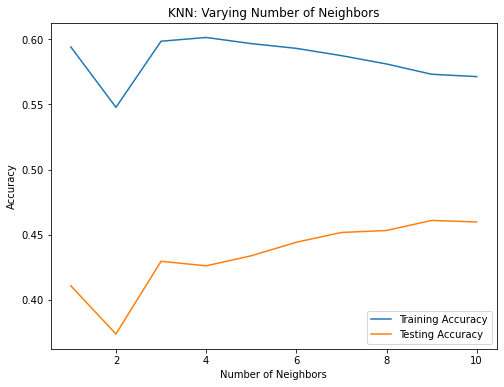

In [11]:
plt.figure(figsize=(8, 6))
plt.title("KNN: Varying Number of Neighbors")
plt.plot(neighbors, train_accuracies.values(), label="Training Accuracy")
plt.plot(neighbors, test_accuracies.values(), label="Testing Accuracy")

plt.legend()
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.show()


### LogisticRegression

In [16]:
from sklearn.linear_model import LogisticRegression, LinearRegression

X = df_eind.drop("score", axis=1)
y = df_eind['score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
fifa_model = LogisticRegression(random_state = 42)
fifa_model.fit(X_train, y_train)
display(fifa_model.score(X_test, y_test))


0.5227097767513472